In [36]:
# Load the required packages

import pandas as pd
import numpy as np 
import re

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# import the feature_extract file to perform feature extraction process
%run feature_extraction.py
from feature_extraction import FeatureExtract, PredictURL

import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import timeit
from math import sqrt

## Loading the phishing dataset

In [2]:
#Load the dataset into dataframe

phishing_raw_df = pd.read_csv("Main_dataset.csv", header = 0)

In [3]:
# Dropping null values, duplicates and reset the index

phishing_raw_df = phishing_raw_df.dropna()
phishing_raw_df = phishing_raw_df.drop_duplicates()
phishing_raw_df = phishing_raw_df.reset_index(drop=True)
phishing_raw_df.shape

(72363, 12)

In [4]:
print(phishing_raw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72363 entries, 0 to 72362
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   domain          72363 non-null  object
 1   ranking         72363 non-null  int64 
 2   isIp            72363 non-null  int64 
 3   valid           72363 non-null  int64 
 4   activeDuration  72363 non-null  int64 
 5   urlLen          72363 non-null  int64 
 6   is@             72363 non-null  int64 
 7   isredirect      72363 non-null  int64 
 8   haveDash        72363 non-null  int64 
 9   domainLen       72363 non-null  int64 
 10  nosOfSubdomain  72363 non-null  int64 
 11  label           72363 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.6+ MB
None


## Data Pre-processing

Class Legitimate URL: 31025
Class Phishing URL: 41338
Proportion: 0.75 : 1


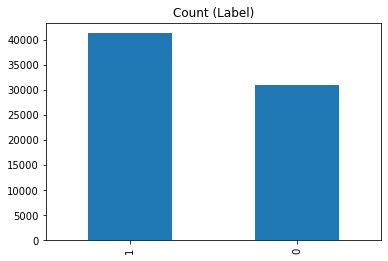

In [5]:
# Plotting a bar graph with the number of Legitimate and Phishing class urls

target_count = phishing_raw_df.label.value_counts()
print('Class Legitimate URL:', target_count[0])
print('Class Phishing URL:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

phishing_raw_df.label.value_counts().plot(kind='bar', title='Count (Label)');

Random under-sampling:
0    31025
1    31025
Name: label, dtype: int64


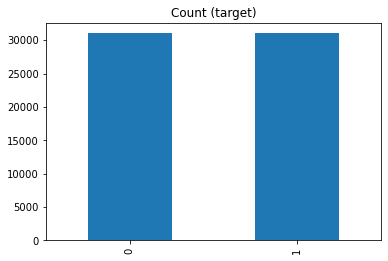

In [6]:
# Each Class count

count_class_1, count_class_0 = phishing_raw_df.label.value_counts()

# Divide by each class

df_class_0 = phishing_raw_df[phishing_raw_df['label'] == 0]
df_class_1 = phishing_raw_df[phishing_raw_df['label'] == 1]

# As the class 1 values are more than to class 0,
# Undersampling is performed to avoid bias and have same number of urls in both classes

df_class_1_under = df_class_1.sample(count_class_0)
phishing_raw_df = pd.concat([df_class_1_under, df_class_0], axis=0)

print('Random under-sampling:')
print(phishing_raw_df.label.value_counts())

phishing_raw_df.label.value_counts().plot(kind='bar', title='Count (target)');

In [7]:
# Viewing sample data from dataframe

phishing_raw_df.head()

,domain,ranking,isIp,valid,activeDuration,urlLen,is@,isredirect,haveDash,domainLen,nosOfSubdomain,label
28874,kandycrew.com.au/us/webscr.php?cmd=_login-run&...,10000000,0,0,0,183,0,0,0,16,2,1
67648,www.wor1dofwarcraft.com/login/login.asp?ref=ww...,10000000,0,1,366,88,0,0,0,23,2,1
15398,jovemvip.com.br/expopec/Area_Segura/www.promoc...,10000000,0,1,4018,137,0,0,0,15,2,1
67454,paypal.com.restore.engine1.verification.update...,10000000,0,1,4018,139,0,0,0,112,10,1
30689,bit.ly/Uxv5Lz,3832,0,0,0,13,0,0,0,6,1,1


## Data Transformation

In [8]:
# Object created for the features class imported from feature_extract file
# This class has the methods that extracts features given the URL

feature = FeatureExtract()

In [9]:
# Insert a new column to the dataframe which shows if 'http' is found in the domain part of the URL.

phishing_raw_df["Domain_http"] = phishing_raw_df["domain"].apply( lambda x: feature.httpDomain(x))

# Insert a new column to the dataframe indicating the length of the URL.

phishing_raw_df["LongURL"] = phishing_raw_df["domain"].apply( lambda x: feature.LongURL(x))

# Insert a new column to the dataframe indicating if the URL belongs to any of the shortening services.

phishing_raw_df["TinyURL"] = phishing_raw_df["domain"].apply( lambda x: feature.tinyURL(x))

# Alter the values in 'nosOfSubdomain' column of the dataframe.
# If the number of sub domains is more than 1, then it is a phishing site.

phishing_raw_df["nosOfSubdomain"] = phishing_raw_df["domain"].apply( lambda x: feature.no_sub_domain(x))

# Alter the values in 'activeDuration' column of the dataframe.
# If the value is greater than 365 (1 year), then it is a legitimate site.

phishing_raw_df["activeDuration"] = phishing_raw_df["activeDuration"].apply( lambda x: 1 if x <= 365 else 0)

# Alter the values in the dataframe column 'ranking'
# If the value is greater than 100000, then it is a phishing site

phishing_raw_df["ranking"] = phishing_raw_df["ranking"].apply( lambda x: 0 if x < 100000 else 1)

# Remove the unwanted columns from the dataframe

phishing_raw_df.drop(['urlLen','domainLen','domain'], inplace=True,axis=1)

# Reorder and rename the columns in the dataframe

Columns = ['Rank','isIP','isValid','Domain_reg_len','is@','isRedirect','haveDash','SubDomain','Label','Domain_http','LongURL','TinyURL']
new_columns = ['Rank','isIP','isValid','Domain_reg_len','is@','isRedirect','haveDash','SubDomain','Domain_http','LongURL','TinyURL','Label']
phishing_raw_df.columns = Columns
phishing_raw_df = phishing_raw_df.reindex(columns=new_columns)
phishing_raw_df1 = phishing_raw_df.copy(deep=True)
phishing_raw_df1.drop(['Domain_http'],inplace=True,axis=1)

# Shuffle the rows in the dataset so that when splitting the train and test set are equally distributed

phishing_raw_df = phishing_raw_df.sample(frac=1).reset_index(drop=True)

# Save the dataframe to a csv file 

phishing_raw_df.to_csv('phishing_feature_engg.csv', encoding='utf-8')

#Display the dataset after data pre-processing

phishing_raw_df.head()

,Rank,isIP,isValid,Domain_reg_len,is@,isRedirect,haveDash,SubDomain,Domain_http,LongURL,TinyURL,Label
0,1,0,1,0,0,0,0,1,0,1,0,1
1,1,0,1,0,0,0,0,1,0,1,0,1
2,0,0,1,0,0,0,0,1,0,0,0,0
3,1,0,0,1,0,0,0,0,0,1,0,1
4,1,0,0,1,0,0,0,1,0,1,0,1


In [10]:
# Check for null values

phishing_raw_df.isnull().sum()

Rank              0
isIP              0
isValid           0
Domain_reg_len    0
is@               0
isRedirect        0
haveDash          0
SubDomain         0
Domain_http       0
LongURL           0
TinyURL           0
Label             0
dtype: int64

## Data Statistics

In [11]:
phishing_raw_df.describe()

,Rank,isIP,isValid,Domain_reg_len,is@,isRedirect,haveDash,SubDomain,Domain_http,LongURL,TinyURL,Label
count,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000,62050.0,62050.000000,62050.000000,62050.000000
mean,0.662111,0.000177,0.594376,0.410540,0.002434,0.006479,0.142562,0.549654,0.0,0.353892,0.069396,0.500000
std,0.472994,0.013313,0.491016,0.491936,0.049271,0.080230,0.349629,0.497532,0.0,0.478180,0.254128,0.500004
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.500000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


<AxesSubplot:>

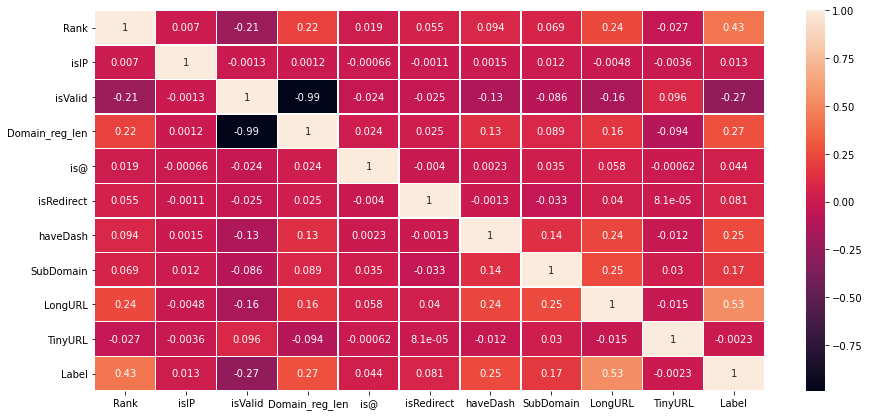

In [12]:
# Heat Map

plt.figure(figsize=(15,7))
sns.heatmap(phishing_raw_df1.corr(),annot=True, linewidth=0.5)

In [13]:
# Label column was dropped and stored the feature data in X
X=phishing_raw_df.drop(["Label"],axis=1)

# store the labels in y
Y=phishing_raw_df["Label"]

#split the data
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=101)

In [14]:
# Fit the data with decision tree classifier to identify feature importance

dtc = DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth = 5)
dtc.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=100)

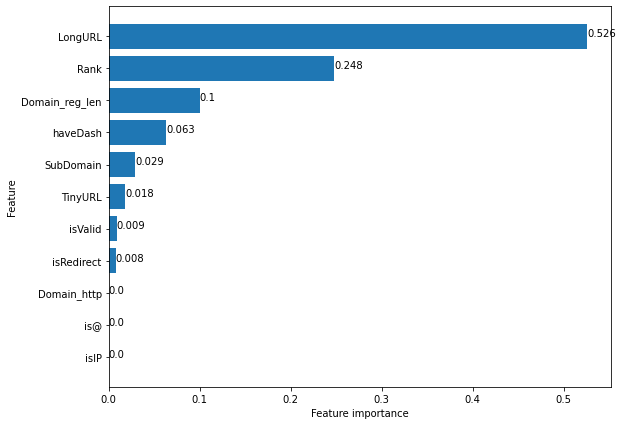

In [15]:
# Get the feature importance for all the features, from the decision tree classifier

importances = dtc.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(9,7))
n_features = X_train.shape[1]
plt.barh(range(n_features), importances[indices], align='center')
plt.yticks(np.arange(n_features), X_train.columns[indices])
for index, value in enumerate(importances[indices]):
    plt.text(value, index, str(round(value,3)))
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()


In [16]:
# Drop the features with least importance and assign the input and output
# variables from the dataset

phishing_raw_df.drop(["isIP","Domain_http","is@"],inplace=True,axis=1)
X = phishing_raw_df.iloc[:, :8]
Y = phishing_raw_df["Label"]

In [17]:
# Split the data for training and testing 

X_train, X_test, y_train, y_test = train_test_split(X.values,Y.values, test_size=0.3, random_state=101)

## Model Development

### XGBoost

In [18]:
def XG_Boost_classifier():
    
    # Funtion for XGBoost model
    
    global XGB_model
    
    XGB_model = XGBClassifier(random_state=100)
    
    train_start = timeit.default_timer()
    XGB_model.fit(X_train, y_train)
    train_time = timeit.default_timer() - train_start
    
    test_start = timeit.default_timer()
    pred_XGB_test = XGB_model.predict(X_test)
    test_time = timeit.default_timer() - test_start
    
    pred_XGB_train = XGB_model.predict(X_train)
    kappa_XGB = cohen_kappa_score(y_test, pred_XGB_test)
    
    # Print the classification report

    print('\n---------- XGBoost ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_XGB_test, target_names=['0','1']))
    
    # Print the Confusion matrix
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_XGB_test),display_labels=['0','1'])
    print('\nConfusion matrix:\n',disp.plot())
    
    # Print the precision-recall graph
    
    plot_precision_recall_curve(XGB_model, X_test, y_test, name = 'XGBoost')
    
    return (('XGBoost',accuracy_score(y_train,pred_XGB_train),accuracy_score(y_test,pred_XGB_test),kappa_XGB, train_time,test_time))


## Decision Tree

In [19]:
def Decision_Tree_classifier():
    
    # Funtion for Decision Tree model
    
    global DTC_model
    
    DTC_model = DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth = 5)
    
    train_start = timeit.default_timer()
    DTC_model.fit(X_train,y_train)
    train_time = timeit.default_timer() - train_start
    
    test_start = timeit.default_timer()
    pred_dtc_test = DTC_model.predict(X_test)
    test_time = timeit.default_timer() - test_start
    
    pred_dtc_train = DTC_model.predict(X_train)
    kappa_dtc = cohen_kappa_score(y_test, pred_dtc_test)
    
    # Print the classification report
    
    print('\n---------- Decision Tree ----------\n')
    print('Classification Report :\n', classification_report(y_test, pred_dtc_test, target_names=['0','1']))
    
    # Print the Confusion matrix
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_dtc_test),display_labels=['0','1'])
    print('\nConfusion matrix:\n',disp.plot())
    
    # Print the precision-recall graph
    
    plot_precision_recall_curve(DTC_model, X_test, y_test, name = 'Decision Tree')
    
    return (('Decision Tree',accuracy_score(y_train,pred_dtc_train),accuracy_score(y_test,pred_dtc_test), kappa_dtc, train_time,test_time))

## Neural Network

In [20]:
def Neural_Network_classifier():
    
    # Funtion for Neural Network model
    # The neural network is trained with 3 layers 
    global MLP_model

    MLP_model = MLPClassifier(hidden_layer_sizes=(12,12,12), activation='relu', solver='adam', max_iter=500)
    
    train_start = timeit.default_timer()  
    MLP_model.fit(X_train,y_train)
    train_time = timeit.default_timer() - train_start
    
    test_start = timeit.default_timer()
    pred_NN_test = MLP_model.predict(X_test)
    test_time = timeit.default_timer() - test_start
    
    pred_NN_train = MLP_model.predict(X_train)
    kappa_NN = cohen_kappa_score(y_test, pred_NN_test)
    
    # Print the classification report
    
    print('\n---------- Neural Network ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_NN_test, target_names=['0','1']))
    
    # Print the Confusion matrix
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_NN_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())
    
    # Print the precision-recall graph
    
    plot_precision_recall_curve(MLP_model, X_test, y_test, name = 'Neural Network')
    
    return (('Neural Network',accuracy_score(y_train,pred_NN_train),accuracy_score(y_test,pred_NN_test), kappa_NN, train_time,test_time))

# SVM

In [21]:
def Svm_classifier():
    
    # Funtion for SVM model
    
    global SVM_model
    
    SVM_model = SVC(kernel='poly', degree=9, random_state=12)
    
    train_start = timeit.default_timer()
    SVM_model.fit(X_train, y_train)
    train_time = timeit.default_timer() - train_start
    
    test_start = timeit.default_timer()
    pred_svm_test = SVM_model.predict(X_test)
    test_time = timeit.default_timer() - test_start
    
    pred_svm_train = SVM_model.predict(X_train)
    kappa_svm = cohen_kappa_score(y_test, pred_svm_test)
    
    # Print the classification report
    
    print('\n---------- SVM ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_svm_test, target_names=['0','1']))
    
    # Print the Confusion matrix
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_svm_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())
    
    # Print the precision-recall graph
    
    plot_precision_recall_curve(SVM_model, X_test, y_test, name = 'SVM')
    
    return (('SVM',accuracy_score(y_train,pred_svm_train),accuracy_score(y_test,pred_svm_test), kappa_svm, train_time,test_time))

# Naive Bayes

In [22]:
def Naive_Bayes_classifier():
    
    # Funtion for Naive Bayes model
    
    global NBC_model
    
    NBC_model = BernoulliNB()
    
    train_start = timeit.default_timer()
    NBC_model.fit(X_train,y_train)
    train_time = timeit.default_timer() - train_start
    
    test_start = timeit.default_timer()
    pred_nb_test = NBC_model.predict(X_test)
    test_time = timeit.default_timer() - test_start
    
    pred_nb_train = NBC_model.predict(X_train)
    kappa_nb = cohen_kappa_score(y_test, pred_nb_test)
    
    # Print the classification report
    
    print('\n---------- Naive Bayes ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_nb_test, target_names=['0','1']))
    
    # Print the Confusion matrix
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_nb_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())
    
    # Print the precision-recall graph
    
    plot_precision_recall_curve(NBC_model, X_test, y_test, name = 'Naive Bayes')
    
    return (('Naive Bayes',accuracy_score(y_train,pred_nb_train),accuracy_score(y_test,pred_nb_test),kappa_nb, train_time,test_time))

# Logistic Regression

In [23]:
def Logistic_Regression_classifier():
    
    # Funtion for Logistic Regression model
    
    global LOG_model

    LOG_model = LogisticRegression(random_state=100)
    
    train_start = timeit.default_timer()
    LOG_model.fit(X_train,y_train)
    train_time = timeit.default_timer() - train_start
    
    test_start = timeit.default_timer()
    pred_logreg_test = LOG_model.predict(X_test)
    test_time = timeit.default_timer() - test_start
   
    pred_logreg_train = LOG_model.predict(X_train)
    kappa_lg =  cohen_kappa_score(y_test, pred_logreg_test)
    
    # Print the classification report
    
    print('\n---------- Logistic Regression ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_logreg_test, target_names=['0','1']))
    
    # Print the Confusion matrix
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_logreg_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())
    
    # Print the precision-recall graph
    
    plot_precision_recall_curve(LOG_model, X_test, y_test, name = 'Logistic Regression')
    
    return (('Logistic Regression',accuracy_score(y_train,pred_logreg_train),accuracy_score(y_test,pred_logreg_test),kappa_lg, train_time,test_time))

# RandomForest

In [24]:
def Random_Forest_classifier():
    
    # Funtion for Random Forest model
    
    global RFC_model
    
    RFC_model = RandomForestClassifier(criterion='entropy',random_state=100)
    
    train_start = timeit.default_timer()
    RFC_model.fit(X_train, y_train)
    train_time = timeit.default_timer() - train_start
    
    test_start = timeit.default_timer()
    pred_RF_test = RFC_model.predict(X_test)
    test_time = timeit.default_timer() - test_start
    
    pred_RF_train = RFC_model.predict(X_train)
    kappa_rf = cohen_kappa_score(y_test, pred_RF_test)
    
    # Print the classification report
    
    print('\n---------- Random Forest ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_RF_test, target_names=['0','1']))
    
    # Print the Confusion matrix
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_RF_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())
    
    # Print the precision-recall graph
    
    plot_precision_recall_curve(RFC_model, X_test, y_test, name = 'Random Forest')
    
    return (('Random Forest',accuracy_score(y_train,pred_RF_train),accuracy_score(y_test,pred_RF_test),kappa_rf, train_time, test_time))

## Evaluation Metrics

In [25]:

def Roc_curves():
    
    # Function to display the ROC curves for the models
    plt.figure()
    
    # Add the models to the list that you want to view on the ROC plot
    models = [
    {
        'label': 'Logistic Regression',
        'model': LogisticRegression(random_state=100),
    },
    {
        'label': 'SVM',
        'model': SVC(kernel='linear', C=1.0, random_state=100,probability=True),
    },
    {
        'label': 'NaiveBayes',
        'model': BernoulliNB(),
    },
    {
        'label': 'Decision Tree',
        'model': DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth = 5),
    },
    {
        'label': 'RandomForest',
        'model': RandomForestClassifier(criterion='entropy',random_state=100)
    },
    {
        'label': 'XGBoost',
        'model': XGBClassifier(random_state=100),
    },
    {
        'label': 'Neural Network',
        'model': MLPClassifier(hidden_layer_sizes=(12,12,12), activation='relu', solver='adam', max_iter=500)
    }
    ]

    # Below for loop iterates through your models list
    
    for m in models: 
        model = m['model']                # select the model
        model.fit(X_train, y_train)       # train the model
        y_pred=model.predict(X_test)      # predict the test data
    
    # Compute False postive rate, and True positive rate
    
        fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    
    # Calculate Area under the curve to display on the plot
    
        auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    # Now, plot the computed values
    
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
        
    # Custom settings for the plot 
    
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()   

In [29]:
def call_ml_models():
    
    # Function to invoke all the proposed ML models and consolidates the performace of each model
    
    kappa_list = []
    ML_Model = []
    acc_train = []
    acc_test = []
    train_time = []
    test_time = []
    model_list = [Logistic_Regression_classifier,Naive_Bayes_classifier,Svm_classifier,Decision_Tree_classifier,Random_Forest_classifier,XG_Boost_classifier,Neural_Network_classifier]
    
    # Below loop iterates to invoke each models in the model_list
    
    for model in model_list: 
        res = model()
        ML_Model.append(res[0])
        acc_train.append(res[1])
        acc_test.append(res[2])
        kappa_list.append(res[3]) 
        train_time.append(res[4])
        test_time.append(res[5])
        
    # Call to display the ROC curves of all the models
    
    Roc_curves()
        
    return ML_Model,acc_train,acc_test,kappa_list,train_time,test_time  




---------- Logistic Regression ----------

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80      9270
           1       0.80      0.80      0.80      9345

    accuracy                           0.80     18615
   macro avg       0.80      0.80      0.80     18615
weighted avg       0.80      0.80      0.80     18615


confusion matrix:

---------- Naive Bayes ----------

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.81      0.80      9270
           1       0.81      0.80      0.80      9345

    accuracy                           0.80     18615
   macro avg       0.80      0.80      0.80     18615
weighted avg       0.80      0.80      0.80     18615


confusion matrix:

---------- SVM ----------

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83      9270
           1       

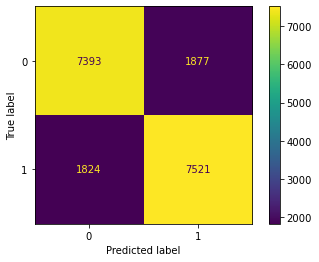

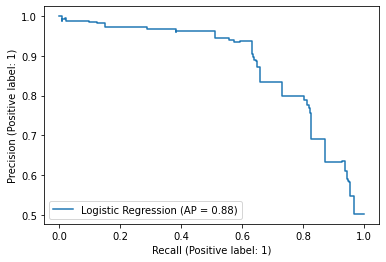

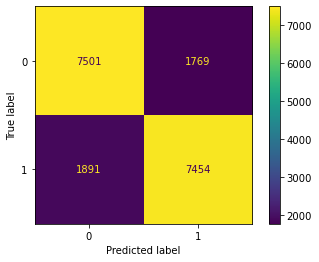

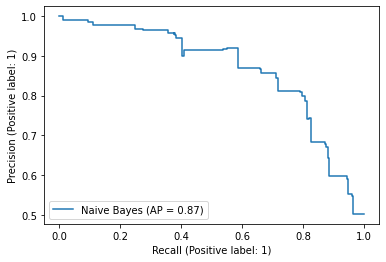

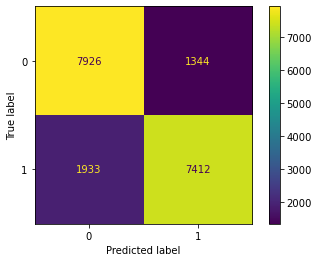

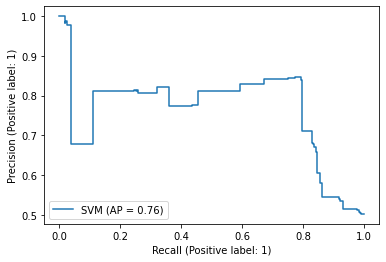

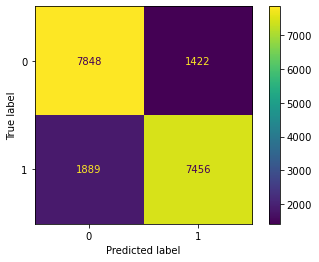

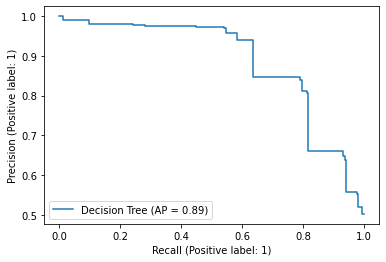

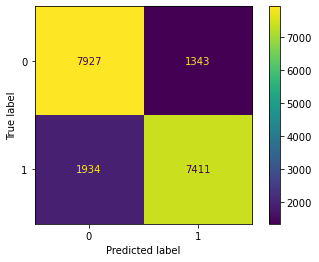

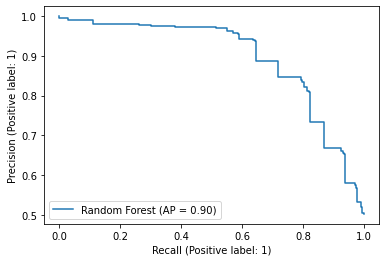

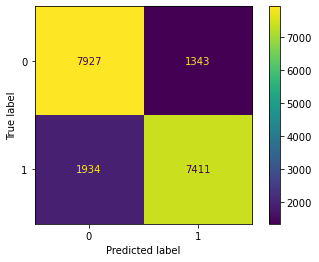

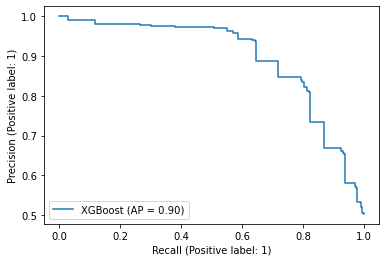

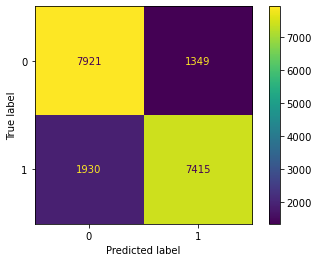

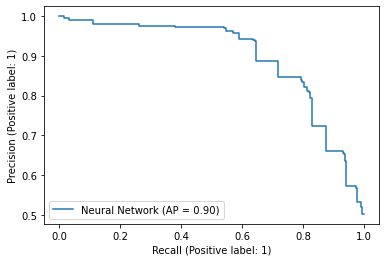

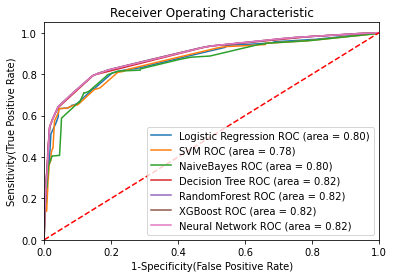

,ML Model,Train Accuracy,Test Accuracy,Kappa Score,Training Time,Testing Time
0,Logistic Regression,0.796731,0.801182,0.602348,0.096612,0.001092
1,Naive Bayes,0.800115,0.803384,0.606783,0.007864,0.001595
2,SVM,0.820076,0.823959,0.648002,27.333839,10.009290
3,Decision Tree,0.818948,0.822133,0.644332,0.009691,0.000905
4,Random Forest,0.820076,0.823959,0.648003,0.609391,0.112813
5,XGBoost,0.820076,0.823959,0.648003,1.067929,0.011160
6,Neural Network,0.819754,0.823852,0.647786,5.041600,0.010224


In [31]:
# Invoke the call models function to display the model performance statistics

ML_Model,acc_train,acc_test,kappa_list,train_time,test_time = call_ml_models()

# Create the dataframe with the consolidated accuracies and timings of all models

results = pd.DataFrame({ 'ML Model': ML_Model, 
    'Train Accuracy': acc_train,
    'Test Accuracy': acc_test, 'Kappa Score': kappa_list,
    'Training Time': train_time, 'Testing Time': test_time})

results # Display results

For the above seleted features, the statistics of the considered models are as shown.<br><br>
The major parameter for the model consideration is test accuracy.<br> Since most of the models have similar accuracy scores, we are considering the training time taken by the model for the considered data set.<br> With these considerations, choose Decision Tree as our final model. Though Random forest and XGBoost have slightly better accuracy scores we are not considering these models as the total number of features are less to be implemented using ensembel techniques.

With Decision Tree as our final model, try to improve the accuracy score using different features by feature selection and hyper parameter tuning.

In [2]:
import pandas as pd
phishing_raw_df = pd.read_csv("Main_dataset.csv")

In [3]:
phishing_raw_df = phishing_raw_df.dropna()
phishing_raw_df = phishing_raw_df.drop_duplicates()
phishing_raw_df = phishing_raw_df.reset_index(drop=True)
phishing_raw_df.shape

(72363, 12)

In [4]:
%run feature_extraction.py
from feature_extraction import FeatureExtract, PredictURL

In [5]:
feature = FeatureExtract()

In [6]:
# Insert a new column to the dataframe indicating the length of the URL.

phishing_raw_df["LongURL"] = phishing_raw_df["domain"].apply( lambda x: feature.LongURL(x))

# Insert a new column to the dataframe indicating if the URL belongs to any of the shortening services.

phishing_raw_df["TinyURL"] = phishing_raw_df["domain"].apply( lambda x: feature.tinyURL(x))

# Alter the values in 'nosOfSubdomain' column of the dataframe.
# If the number of sub domains is more than 1, then it is a phishing site.

phishing_raw_df["nosOfSubdomain"] = phishing_raw_df["domain"].apply( lambda x: feature.no_sub_domain(x))

In [6]:
list(phishing_raw_df.columns)

['domain',
 'ranking',
 'isIp',
 'valid',
 'activeDuration',
 'urlLen',
 'is@',
 'isredirect',
 'haveDash',
 'domainLen',
 'nosOfSubdomain',
 'label',
 'LongURL',
 'TinyURL']

In [7]:
phishing_raw_df=phishing_raw_df[['domain', 'ranking', 'isIp', 'valid', 'activeDuration', 'urlLen', 'is@', 'isredirect', 'haveDash', 'domainLen', 'nosOfSubdomain', 'LongURL', 'TinyURL', 'label']]

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

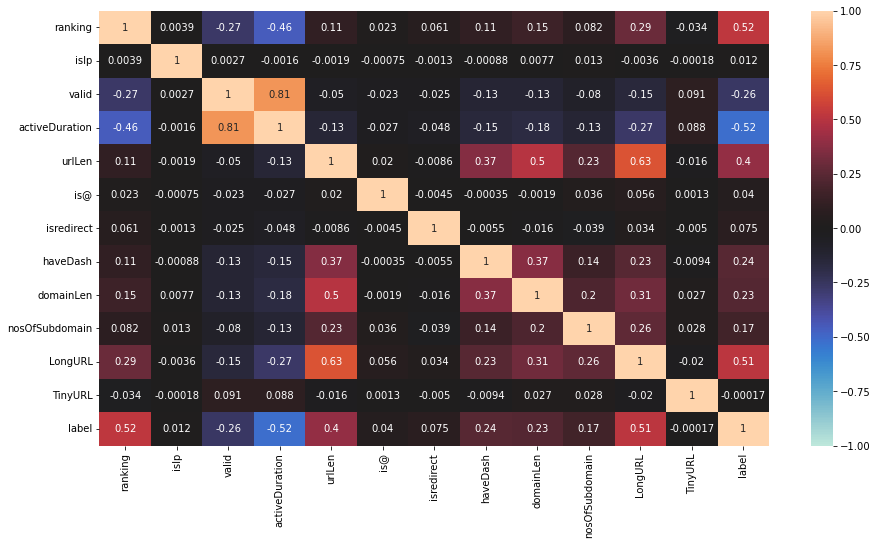

In [9]:
plt.figure(figsize=(15,8))
sns.heatmap(phishing_raw_df.corr(),annot=True,fmt='.2g',cmap=sns.color_palette("icefire", as_cmap=True),vmin=-1,vmax=1)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [9]:
XTrain, XTest, yTrain, yTest = train_test_split(phishing_raw_df.iloc[:,0:-1],phishing_raw_df.iloc[:,-1], test_size=0.2, random_state=101)

In [12]:
dtc = DecisionTreeClassifier()
dtc.fit(XTrain.iloc[:,1:],yTrain)
Importances = dtc.feature_importances_

<AxesSubplot:>

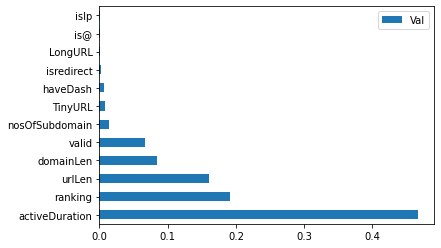

In [13]:
Importances_DF = pd.DataFrame(Importances,index=list(XTrain.columns)[1:],columns=['Val'])
Importances_DF.sort_values(by=['Val'],ascending=False,inplace=True)
Importances_DF.plot.barh()

In the previous method the feature of active duration had been engineered to be binary data based on the condition that if the url is active for less than one year or more than one year. Hence this feature was not noted as important in the first iteration.

In [14]:
Pred = dtc.predict(XTest.iloc[:,1:])

In [14]:
from sklearn.metrics import accuracy_score

In [16]:
print(accuracy_score(yTest,Pred))

0.9179161196711118


Selecting certain features based on the above important features and correlation heatmap

In [10]:
NewDF = phishing_raw_df.loc[:,['activeDuration','ranking','urlLen','LongURL','label']]

In [11]:
NewDF

,activeDuration,ranking,urlLen,LongURL,label
0,0,10000000,20,0,1
1,7305,194914,42,0,0
2,0,10000000,155,1,1
3,0,7001,35,0,0
4,730,10000000,79,1,1
...,...,...,...,...,...
72358,8035,2547,36,0,0
72359,8035,5001,44,0,0
72360,8035,5001,28,0,0
72361,0,10000000,43,0,1


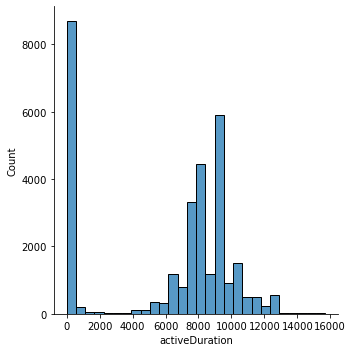

In [37]:
sns.displot(NewDF[NewDF['label']==0]['activeDuration'])

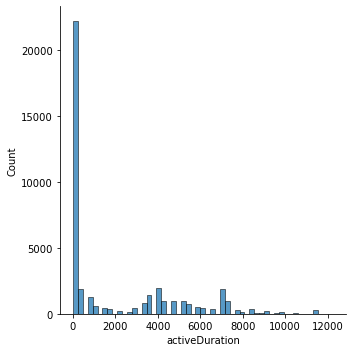

In [38]:
sns.displot(NewDF[NewDF['label']==1]['activeDuration'])

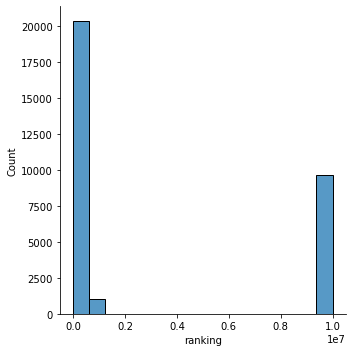

In [39]:
sns.displot(NewDF[NewDF['label']==0]['ranking'])

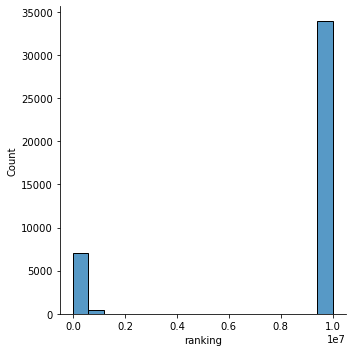

In [40]:
sns.displot(NewDF[NewDF['label']==1]['ranking'])

C:\Users\sasha\AppData\Local\Temp/ipykernel_19316/3866356195.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.displot(NewDF[NewDF['label']==0][NewDF['urlLen']<500]['urlLen'])


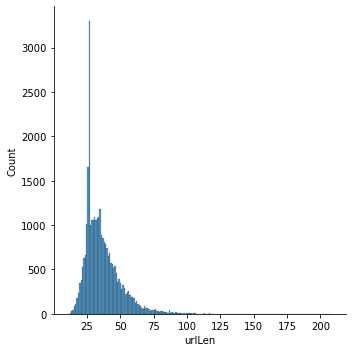

In [44]:
sns.displot(NewDF[NewDF['label']==0][NewDF['urlLen']<500]['urlLen'])

C:\Users\sasha\AppData\Local\Temp/ipykernel_19316/728963283.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.displot(NewDF[NewDF['label']==1][NewDF['urlLen']<500]['urlLen'])


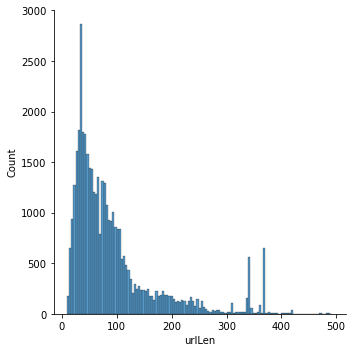

In [45]:
sns.displot(NewDF[NewDF['label']==1][NewDF['urlLen']<500]['urlLen'])

In [12]:
XTrain, XTest, yTrain, yTest = train_test_split(NewDF.iloc[:,0:-1],NewDF.iloc[:,-1], test_size=0.2, random_state=101)

In [21]:
XTrain

,activeDuration,ranking,urlLen,LongURL
51122,3653,117054,20,0
45476,6210,4294,24,0
67458,9862,656,19,0
55845,0,10000000,62,1
34371,0,10000000,35,0
...,...,...,...,...
20463,7305,11,30,0
55293,3653,10000000,21,0
49751,6940,10000000,26,0
5695,1827,10000000,56,1


In [20]:
dtc = DecisionTreeClassifier()
dtc.fit(XTrain,yTrain)
Pred = dtc.predict(XTest)
print(accuracy_score(yTest,Pred))

0.9218544876666896


## Hyper parameter tunning

Now Performing Hyper parameter Tuning for the selected features

In [24]:
Parameters = {'criterion':['gini','entropy'], 
              'splitter':['best','random'], 
              'max_depth':['None',3,4,5,8,10,12,15], 
              'min_samples_split':[2,5,10,0.2,0.5], 
              'ccp_alpha':[0.0,0.01,0.05,0.1,0.3] }

In [22]:
from sklearn.model_selection import GridSearchCV

In [25]:
DTC_Grid = GridSearchCV(dtc,param_grid=Parameters,n_jobs=-1)
DTC_Grid.fit(XTrain,yTrain)

D:\Tools\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.87267231 0.82775954
 0.87267231 0.84828122 0.87267231 0.81701503 0.82829504 0.83399551
 0.82052168 0.77415789 0.89497323 0.85349801 0.89497323 0.84662291
 0.89497323 0.85596822 0.82829504 0.81799965 0.82052168 0.79785801
 0.90212472 0.86714458 0.90212472 0.86809466 0.90212472 0.8662636
 0.82829504 0.83663845 0.82052168 0.78215581 0.91630679 0.89697703
 0.91625497 0.8959924  0.91620314 0.89533598 0.82829504 0.83389186
 0.82052168 0.77752634 0.91981344 0.90506132 0.91977889 0.9029366
 0.91967525 0.90181378 0.82829504 0.82566937 0.82052168 0.77576438
 0.91998618 0.90595958 0.91988254 0.90659872 0.91970979 0.90858525
 0.82829504 0.83734669 0.82052168 0.80956987 0.91780964 0.90899983
 0.91780964 0.90874072 0.91822422 0.90889618 0.82829504 0.8215

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.01, 0.05, 0.1, 0.3],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': ['None', 3, 4, 5, 8, 10, 12, 15],
                         'min_samples_split': [2, 5, 10, 0.2, 0.5],
                         'splitter': ['best', 'random']})

In [26]:
DTC_Grid.best_params_

{'ccp_alpha': 0.0,
 'criterion': 'entropy',
 'max_depth': 12,
 'min_samples_split': 10,
 'splitter': 'best'}

In [15]:
BestDTC = DecisionTreeClassifier(criterion = 'entropy',max_depth=12,min_samples_split=10)
BestDTC.fit(XTrain,yTrain)
Pred = BestDTC.predict(XTest)
print(accuracy_score(yTest,Pred))

0.9262074207144337


In [28]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(yTest, Pred))

0.8441962238662144


## Save the model

In [29]:
def save_model(model):
    
    # Function to save the required model using pickle
    
    with open('phishing_classifier.pkl', 'wb') as f:
        pickle.dump(model, f, -1)
        f.close()


        
save_model(BestDTC)

## Perform the classification using the saved model

In [31]:
classification = PredictURL()

In [32]:
classification.predict('www.anaconda.com')

'Given website is a legitimate site'

In [33]:
classification.predict('www.sjsu.com')

'Given website is a phishing site'